In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from helpers import CausalModel, lfilter, create_standardizer_destandardizer
from copy import deepcopy
import seaborn as sns

In [4]:
%matplotlib Inline

In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

## The Haunted DAG & The Causal Terror

### Code 6.1

Correlation on complete group 0.052
Correlation on selected group -0.652


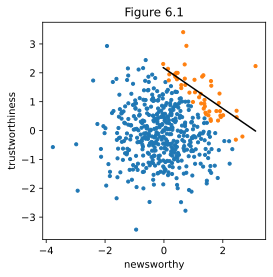

In [7]:
N = 500
p = .1

nw = np.random.normal(size=N)
tw = np.random.normal(size=N)

s = nw + tw

q = np.quantile(s, 1-p)
selected = s >= q

print(f'Correlation on complete group {np.corrcoef(tw, nw)[1, 0]:.3f}')
print(f'Correlation on selected group {np.corrcoef(tw[selected], nw[selected])[1, 0]:.3f}')

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(nw[~selected], tw[~selected], s=10)
ax.scatter(nw[selected], tw[selected], s=10)

beta, alpha = np.polyfit(nw[selected], tw[selected], 1)
ax.plot(nw[selected], alpha + beta*nw[selected], color='black')

ax.set_title('Figure 6.1')
ax.set_xlabel('newsworthy')
ax.set_ylabel('trustworthiness')
plt.show()

### Code 6.2

In [8]:
N = 100

height = np.random.normal(10, 2, size=N)
leg_prop = np.random.uniform(.4, .5, size=N)
leg_left = leg_prop*height + np.random.normal(0, .02, size=N)
leg_right = leg_prop*height + np.random.normal(0, .02, size=N)

d = pd.DataFrame({'height': height, 'leg_left': leg_left, 'leg_right': leg_right})

In [9]:
d.head()

,height,leg_left,leg_right
0,12.217,5.983,5.981
1,10.919,4.468,4.478
2,13.296,6.419,6.412
3,6.921,3.369,3.386
4,12.851,5.913,5.909


### Code 6.3

In [10]:
with pm.Model() as model_61:
    alpha = pm.Normal('alpha', 10, 100)
    beta_left = pm.Normal('beta_left', 2, 10)
    beta_right = pm.Normal('beta_right', 2, 10)
    sigma = pm.Exponential('sigma', 1)
    mu = alpha + beta_left*d['leg_left'] + beta_right*d['leg_right']
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace_61 = pm.sample()

/tmp/ipykernel_4263/3714563718.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_61 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_right, beta_left, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
az.summary(trace_61, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.141,0.302,0.653,1.605
beta_left,1.660,2.191,-1.725,5.169
beta_right,0.302,2.194,-3.158,3.790
sigma,0.607,0.043,0.540,0.678


In [12]:
with pm.Model() as model_61b:
    pm.glm.GLM.from_formula(
        formula='height ~ leg_left + leg_right', 
        data=d,
        priors={
            'Intercept': pm.Normal.dist(10, 100),
            'Regressor': pm.Normal.dist(2, 10),
            'sd': pm.Exponential.dist(1)
        }
    )
    trace_61b = pm.sample()

/tmp/ipykernel_4263/3594111202.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_61b = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, leg_right, leg_left, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
az.summary(trace_61b, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.156,0.305,0.695,1.663
leg_left,1.679,2.271,-2.024,5.209
leg_right,0.280,2.274,-3.281,3.959
sd,0.613,0.043,0.542,0.676


### Code 6.4

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


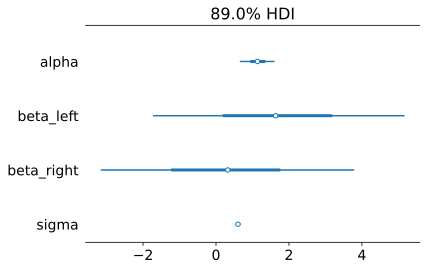

In [14]:
fig, ax = plt.subplots()
az.plot_forest(trace_61, hdi_prob=.89, combined=True, ax=ax)
plt.show()

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


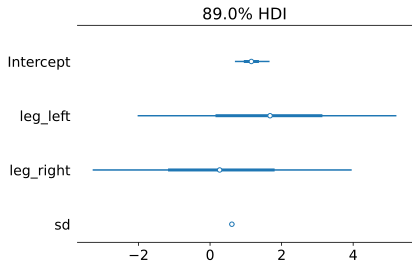

In [15]:
fig, ax = plt.subplots()
az.plot_forest(trace_61b, hdi_prob=.89, combined=True, ax=ax)
plt.show()

### Code 6.5-6.6

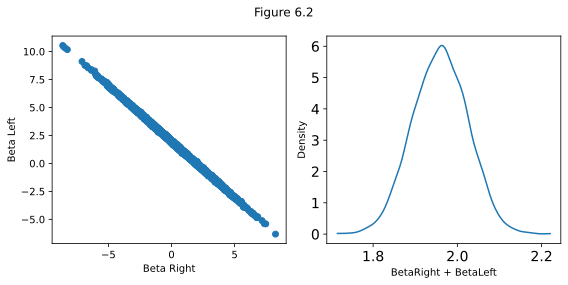

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(trace_61b['leg_right'], trace_61b['leg_left'])
ax1.set_xlabel('Beta Right')
ax1.set_ylabel('Beta Left')

az.plot_dist(trace_61b['leg_right'] + trace_61b['leg_left'], ax=ax2)
ax2.set_xlabel('BetaRight + BetaLeft')
ax2.set_ylabel('Density')

fig.suptitle('Figure 6.2')
fig.tight_layout()
plt.show()

### Code 6.7

In [17]:
with pm.Model() as model_62:
    pm.glm.GLM.from_formula(
        formula="height ~ leg_left",
        data=d,
        priors={
            "Intercept": pm.Normal.dist(10, 100),
            "Regressor": pm.Normal.dist(2, 10),
            "sd": pm.Exponential.dist(1)
        }
    )
    
    trace_62 = pm.sample()

/tmp/ipykernel_4263/446922992.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_62 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, leg_left, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [18]:
az.summary(trace_62, hdi_prob=.89, kind='stats')

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.163,0.310,0.671,1.657
leg_left,1.957,0.066,1.862,2.068
sd,0.610,0.044,0.533,0.673


### Code 6.8

In [19]:
d = pd.read_csv('../../data/milk.csv', sep=';')

std_K, dstd_K = create_standardizer_destandardizer(d['kcal.per.g'])
std_F, dstd_F = create_standardizer_destandardizer(d['perc.fat'])
std_L, dstd_L = create_standardizer_destandardizer(d['perc.lactose'])

d['K'] = std_K(d['kcal.per.g'])
d['F'] = std_F(d['perc.fat'])
d['L'] = std_L(d['perc.lactose'])

### Code 6.9

In [20]:
with pm.Model() as model_63:
    pm.glm.GLM.from_formula(
        formula='K ~ F',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_63 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/78259060.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_63 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, F, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 32 seconds.


In [21]:
with pm.Model() as model_64:
    pm.glm.GLM.from_formula(
        formula='K ~ L',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_64 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/3276022010.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_64 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, L, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 32 seconds.


In [22]:
az.summary(trace_63, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.000,0.084,-0.129,0.138
F,0.857,0.093,0.705,1.000
sd,0.492,0.072,0.378,0.597


In [23]:
az.summary(trace_64, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.001,0.073,-0.117,0.115
L,-0.898,0.079,-1.025,-0.773
sd,0.415,0.060,0.323,0.506


### Code 6.10

In [24]:
with pm.Model() as model_65:
    pm.glm.GLM.from_formula(
        formula='K ~ L + F',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_65 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/1703585172.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_65 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, F, L, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 58 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [25]:
az.summary(trace_65, kind='stats', hdi_prob=.89)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.001,0.074,-0.114,0.120
L,-0.667,0.202,-0.997,-0.356
F,0.253,0.201,-0.065,0.576
sd,0.417,0.062,0.320,0.508


### Code 6.11

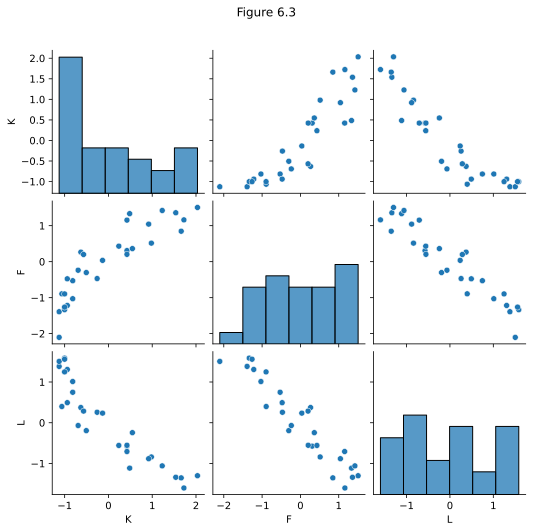

In [26]:
pp = sns.pairplot(d[['K', 'F', 'L']])
pp.fig.subplots_adjust(top=0.9)
pp.fig.suptitle('Figure 6.3')
plt.show()

### Code 6.12

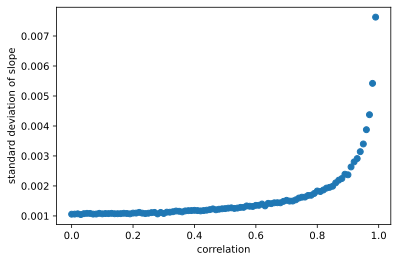

In [27]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(d, r=.9):
    d = d.copy()
    d['x'] = np.random.normal(
        r*d['perc.fat'],
        np.sqrt((1-r**2) * np.var(d['perc.fat']))
    )
    _, cov = curve_fit(mv, (d["perc.fat"], d['x']), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(d, r=0.9, n=100):
    return np.mean([sim_coll(d, r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(lambda x: rep_sim_coll(d, x), r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

### Code 6.13

In [28]:
N = 100

h0 = np.random.normal(10, 2, N)

treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
p = h1/h0

d = pd.DataFrame({
    "h0": h0,
    "h1": h1,
    "treatment": treatment,
    "fungus": fungus,
    "p": p,
})

d.describe()

,h0,h1,treatment,fungus,p
count,100.000,100.000,100.000,100.000,100.000
mean,10.132,14.367,0.500,0.280,1.441
std,2.243,2.803,0.503,0.451,0.218
min,5.154,6.702,0.000,0.000,0.930
25%,8.756,12.788,0.000,0.000,1.326
50%,10.344,14.506,0.500,0.000,1.414
75%,11.681,16.301,1.000,1.000,1.588
max,15.376,19.575,1.000,1.000,1.972


### Code 6.14

In [29]:
sim_p = pd.Series(np.random.lognormal(0, .25, size=1000))


In [30]:
sim_p.describe()

count   1,000.000
mean        1.016
std         0.255
min         0.517
25%         0.831
50%         0.976
75%         1.177
max         2.093
dtype: float64

<AxesSubplot:>

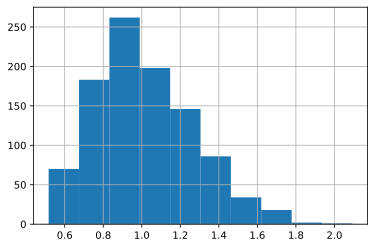

In [31]:
sim_p.hist()

### Code 6.15

In [32]:
with pm.Model() as model_66:
    p = pm.Lognormal('p', 0, .25)
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', p * d['h0'], sigma, observed=d['h1'])
    
    trace_66 = pm.sample(10_000, tune=10_000)

/tmp/ipykernel_4263/1132193321.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_66 = pm.sample(10_000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 21 seconds.


In [33]:
az.summary(trace_66, hdi_prob=.89, kind='stats', round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
p,1.400,0.020,1.360,1.430
sigma,2.050,0.150,1.810,2.270


### Code 6.16

In [34]:
with pm.Model() as model_67:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment + fungus',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_67 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/2137954593.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_67 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, fungus, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.6387425095248823, but should be close to 0.8. Try to increase the number of tuning steps.


In [35]:
az.summary(trace_67, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.560,0.030,1.500,1.610
treatment,-0.060,0.040,-0.130,-0.000
fungus,-0.340,0.040,-0.410,-0.270
sd,0.160,0.010,0.140,0.180


### Code 6.17

In [36]:
d['p'] = d['h1'] / d['h0']

with pm.Model() as model_68:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment',
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_68 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/1243007833.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_68 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 31 seconds.


In [37]:
az.summary(trace_68, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.370,0.030,1.320,1.420
treatment,0.110,0.040,0.040,0.180
sd,0.220,0.020,0.190,0.250


### Code 6.18

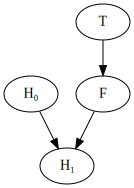

In [38]:
plant_dag = CausalModel(
    nodes=['H\N{SUBSCRIPT ZERO}', 'H\N{SUBSCRIPT ONE}', 'F', 'T'],
    edges=[
        ('H\N{SUBSCRIPT ZERO}', 'H\N{SUBSCRIPT ONE}'),
        ('F', 'H\N{SUBSCRIPT ONE}'),
        ('T', 'F'),
    ]
)

plant_dag.draw()

### Code 6.19

In [39]:
plant_dag.get_all_independence_relationships()

[('H₁', 'T', {'F'}),
 ('H₁', 'T', {'F', 'H₀'}),
 ('T', 'H₀', set()),
 ('T', 'H₀', {'F'}),
 ('T', 'H₀', {'F', 'H₁'}),
 ('H₀', 'F', set()),
 ('H₀', 'F', {'T'})]

In [40]:
plant_dag.get_implied_conditional_independencies()

[('H₁', 'T', {'F'}), ('T', 'H₀', set()), ('H₀', 'F', set())]

### Code 6.20

In [41]:
N = 1000

h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(n=1, p=0.5, size=N)
fungus = np.random.binomial(n=1, p=0.5 - .4*treatment + .4*M, size=N)
h1 = h0 + np.random.normal(5 + 3*M, size=N)
p = h1/h0

d2 = pd.DataFrame({
    "h0": h0,
    "h1": h1,
    "treatment": treatment,
    "fungus": fungus,
    "p": p,
})

d2.describe()

,h0,h1,treatment,fungus,p
count,"1,000.000","1,000.000","1,000.000","1,000.000","1,000.000"
mean,9.958,16.439,0.500,0.484,1.681
std,2.055,2.767,0.500,0.500,0.251
min,4.027,7.449,0.000,0.000,1.185
25%,8.551,14.554,0.000,0.000,1.495
50%,9.981,16.412,0.500,0.000,1.649
75%,11.314,18.342,1.000,1.000,1.830
max,18.125,27.322,1.000,1.000,2.825


In [42]:
d2['p'] = d2['h1'] / d2['h0']

with pm.Model() as model_672:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment + fungus',
        data=d2,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_672 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/2727862862.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_672 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, fungus, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 254 seconds.
The acceptance probability does not match the target. It is 0.571174701147175, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6890769276365587, but should be close to 0.8. Try to increase the number of tuning steps.


In [43]:
az.summary(trace_672, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.540,0.020,1.510,1.570
treatment,0.110,0.020,0.080,0.140
fungus,0.170,0.020,0.140,0.200
sd,0.240,0.010,0.230,0.250


In [44]:
d['p'] = d['h1'] / d['h0']

with pm.Model() as model_682:
    pm.glm.GLM.from_formula(
        formula='p ~ treatment',
        data=d2,
        priors={
            'Intercept': pm.Normal.dist(0, .2),
            'Regressor': pm.Normal.dist(0, .5),
        }
    )
    
    trace_682 = pm.sample(10_000, tune=20_000)

/tmp/ipykernel_4263/335932195.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_682 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, treatment, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 202 seconds.
The acceptance probability does not match the target. It is 0.88255843684908, but should be close to 0.8. Try to increase the number of tuning steps.


In [45]:
az.summary(trace_682, kind='stats', hdi_prob=.89, round_to=2)

/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,1.660,0.010,1.640,1.680
treatment,0.040,0.020,0.010,0.070
sd,0.250,0.010,0.240,0.260


/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


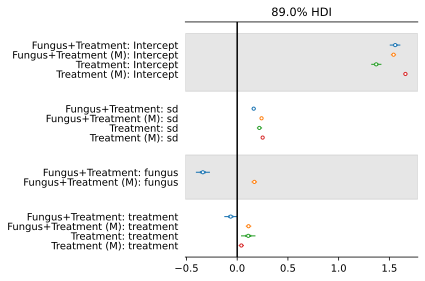

In [46]:
fig, ax = plt.subplots()

az.plot_forest(
    data=[trace_67, trace_672, trace_68, trace_682],
    model_names=['Fungus+Treatment', 'Fungus+Treatment (M)', 'Treatment', 'Treatment (M)'],
    combined=True,
    hdi_prob=.89,
    ax=ax,
    textsize=10,
)
ax.axvline(0, color='black')
fig.tight_layout()
plt.show()

### Code 6.21

In [47]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def create_pop(n):
    population = pd.DataFrame({
        'age': np.zeros(shape=n),
        'happiness': np.linspace(start=-2, stop=2, num=n),
        'married': np.zeros(shape=n, dtype='bool')
    })
    
    return population

def sim_happiness(born_on_year: int = 20, 
                  max_age: int = 65, 
                  n_years: int = 100) -> pd.DataFrame:
    
    population = create_pop(born_on_year)
    
    for _ in range(n_years):
        population['age'] += 1
        
        # Create and remove pop
        population = population[population['age'] < 65]
        population = pd.concat([population, create_pop(born_on_year)], ignore_index=True)
        
        # Marry pop
        marriable = (population['age'] > 18) & (population['married'] == False)
        marrying = np.random.binomial(n=1, p=inv_logit(population.loc[marriable, "happiness"] - 4)).astype('bool')
        population.loc[marriable, 'married'] = marrying
        
    return population

d = sim_happiness(n_years=1000)

d.describe().T

,count,mean,std,min,25%,50%,75%,max
age,"1,300.000",32.000,18.769,0.000,16.000,32.000,48.000,64.000
happiness,"1,300.000",-0.000,1.214,-2.000,-1.000,-0.000,1.000,2.000


### Code 6.22

In [48]:
d2 = d[d['age'] >= 18].reset_index(drop=True)
d2['age_norm'] = (d2['age'] - d2['age'].min()) / (d2['age'].max() - d2['age'].min())

### Code 6.23

In [49]:
with pm.Model() as model_69:
    pm.glm.GLM.from_formula(
        formula='happiness ~ -1 + age_norm + C(married)',
        data=d2,
        priors={
            'C(married)[True]': pm.Normal.dist(0, 1),
            'C(married)[False]': pm.Normal.dist(0, 1),
            'age_norm': pm.Normal.dist(0, 2),
        }
    )
    
    trace_69 = pm.sample(10_000, tune=20_000)

az.summary(trace_69, kind='stats', hdi_prob=.89, round_to=2)

/tmp/ipykernel_4263/4268959170.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_69 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, age_norm, C(married)[True], C(married)[False]]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 233 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
C(married)[False],-0.190,0.070,-0.300,-0.080
C(married)[True],1.270,0.090,1.120,1.420
age_norm,-0.700,0.120,-0.880,-0.500
sd,1.010,0.020,0.970,1.050


### Code 6.24

In [50]:
with pm.Model() as model_610:
    pm.glm.GLM.from_formula(
        formula='happiness ~ -1 + age_norm',
        data=d2,
        priors={
            'age_norm': pm.Normal.dist(0, 2),
        }
    )
    
    trace_610 = pm.sample(10_000, tune=20_000)

az.summary(trace_610, kind='stats', hdi_prob=.89, round_to=2)

/tmp/ipykernel_4263/2836782778.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_610 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, age_norm]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 24 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
age_norm,0.000,0.070,-0.110,0.110
sd,1.220,0.030,1.170,1.260


### Code 6.25

In [51]:
N = 200 # Number of samples
b_GP = 1 # direct effect of Grandparents on Parents
b_GC = 0 # direct effect of Grandparents on Children
b_PC = 1 # direct effect of Parents on Children
b_U = 2 # direct effect of Unknown on Parents and Children

### Code 6.26

In [52]:
U = 2 * stats.bernoulli(p=.5).rvs(N) - 1
G = stats.norm().rvs(N)
P = stats.norm(b_GP*G + b_U*U).rvs(N)
C = stats.norm(b_GC*G + b_U*U + b_PC*P).rvs(N)

d = pd.DataFrame({
    'U': U,
    'G': G,
    'P': P,
    'C': C,
})

d.head()

,U,G,P,C
0,1,-1.040,0.958,2.998
1,-1,-1.343,-2.680,-4.723
2,1,0.561,1.253,3.788
3,-1,0.075,-1.485,-4.449
4,1,-0.816,0.587,4.053


### Code 6.27

In [53]:
with pm.Model() as model_611:
    pm.glm.GLM.from_formula(
        formula="C ~ P + G",
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, 1),
            'Regressor': pm.Normal.dist(0, 1),
        }
    )
    
    trace_611 = pm.sample(10_000, tune=20_000)
    
az.summary(trace_611, kind='stats', hdi_prob=.89)

/tmp/ipykernel_4263/4101515830.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_611 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, G, P, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 28 seconds.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.088,0.097,-0.063,0.246
P,1.776,0.043,1.708,1.845
G,-0.696,0.106,-0.868,-0.528
sd,1.363,0.069,1.258,1.477


### Code 6.28

In [54]:
with pm.Model() as model_612:
    pm.glm.GLM.from_formula(
        formula="C ~ P + G + U",
        data=d,
        priors={
            'Intercept': pm.Normal.dist(0, 1),
            'Regressor': pm.Normal.dist(0, 1),
        }
    )
    
    trace_612 = pm.sample(10_000, tune=20_000)
    
az.summary(trace_612, kind='stats', hdi_prob=.89)

/tmp/ipykernel_4263/2740015589.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_612 = pm.sample(10_000, tune=20_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, U, G, P, Intercept]


Sampling 4 chains for 20_000 tune and 10_000 draw iterations (80_000 + 40_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.6809359174585564, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6685573929736364, but should be close to 0.8. Try to increase the number of tuning steps.
/home/giuliano/.pyenv/versions/miniconda3-4.7.12/envs/statistical-rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
Intercept,0.045,0.071,-0.072,0.157
P,0.970,0.070,0.857,1.081
G,0.162,0.102,-0.001,0.325
U,2.043,0.160,1.781,2.290
sd,1.001,0.051,0.919,1.082


### Code 6.29

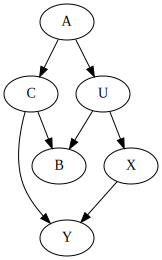

In [55]:
dag_61 = CausalModel(
    nodes=['A', 'B', "C", "X", "Y", "U"],
    edges=[
        ('A', 'C'),
        ('A', 'U'),
        ('C', 'B'),
        ('C', 'Y'),
        ('X', 'Y'),
        ('U', 'X'),
        ('U', 'B'),
    ]
)

dag_61.draw()

In [56]:
lfilter(lambda x: x != {"U"}, dag_61.get_adjustment_sets('X', 'Y'))

[frozenset({'A'}), frozenset({'C'})]

### Code 6.30

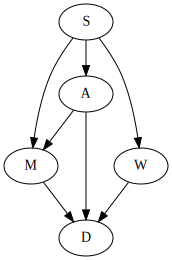

In [57]:
dag_62 = CausalModel(
    nodes=['S', 'W', "M", "A", "D"],
    edges=[
        ('S', 'W'),
        ('S', 'A'),
        ('S', 'M'),
        ('W', 'D'),
        ('M', 'D'),
        ('A', 'D'),
        ('A', 'M'),
    ]
)

dag_62.draw()

In [58]:
dag_62.get_adjustment_sets('W', 'D')

[frozenset({'S'}), frozenset({'A', 'M'})]